In [1]:
%matplotlib inline

In [2]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from vtk_rw import read_vtk
from plotting import plot_surf_stat_map, crop_img # from https://github.com/juhuntenburg/brainsurfacescripts
import matplotlib as mpl
import cmocean 
from nilearn import plotting
import scipy.stats as stats

/home/raid3/huntenburg/workspace/anaconda2/envs/myelinconnect/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
def load_pickle(pkl_file):
    pkl_in = open(pkl_file, 'r')
    pkl_dict = pickle.load(pkl_in)
    pkl_in.close()
    return pkl_dict

In [75]:
def brain_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(12,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

def dorsal_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(8,rows*10))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

def occ_fig(plot_list):
    sns.set_style('white')
    n = len(plot_list)
    rows = int(n/2)
    fig = plt.figure(figsize=(6,rows*5))
    for img in range(n):
        ax = fig.add_subplot(rows,2,img+1)
        plt.imshow(plot_list[img])
        ax.set_axis_off()
    fig.tight_layout()
    return fig

In [6]:
infl=150
lh_mesh_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_taubin_%i.vtk'%infl
lh_sulc_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/lh_lowres_new_taubin_%i_sulc.npy'%infl
rh_mesh_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_taubin_%i.vtk'%infl
rh_sulc_file = '/nobackup/ilz3/myelinconnect/new_groupavg/surfs/lowres/inflated/rh_lowres_new_taubin_%i_sulc.npy'%infl
fullmask_file = '/nobackup/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_new.npy'
vizmaks_file = '/nobackup/ilz3/myelinconnect/new_groupavg/masks/fullmask_lh_rh_viz.npy'
lh_sulc = np.load(lh_sulc_file)
lv, lf, _ = read_vtk(lh_mesh_file)
rh_sulc = np.load(rh_sulc_file)
rv, rf, _ = read_vtk(rh_mesh_file)
fullmask = np.load(fullmask_file)
vizmask = np.load(vizmaks_file)

In [7]:
embed_file='/nobackup/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed.npy'
#embed_viz_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_viz.npy'
dict_file='/nobackup/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict.pkl'
#dict_viz_file='/scr/ilz3/myelinconnect/new_groupavg/embed/both_smooth_3_embed_dict_viz.pkl'

embed_dict = load_pickle(dict_file)
eigenval=embed_dict['lambdas']
perc_var = eigenval/np.sum(eigenval)*100
# normalize vectors
embed_masked = np.zeros((embed_dict['vectors'].shape[0], embed_dict['vectors'].shape[1]-1))
for comp in range(100):
    embed_masked[:,comp]=(embed_dict['vectors'][:,comp+1]/embed_dict['vectors'][:,0])

# unmask the embedding, that has been saved in masked form
idcs=np.arange(0,(lv.shape[0]+rv.shape[0]))
nonmask=np.delete(idcs, fullmask)
embed = np.zeros(((lv.shape[0]+rv.shape[0]),100))
embed[nonmask] = embed_masked

In [40]:
profiles_lh = np.load('/nobackup/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/lh_group_avg_profiles_smooth_3.npy')
profiles_rh = np.load('/nobackup/ilz3/myelinconnect/new_groupavg/profiles/smooth_3/rh_group_avg_profiles_smooth_3.npy')
profiles = np.concatenate((profiles_lh, profiles_rh))
profiles[fullmask] = 0
profiles_masked = profiles[nonmask, 3:8]

In [58]:
t1_predict_file_best = '/nobackup/ilz3/myelinconnect/new_groupavg/model/linear_combination/t1avg/smooth_1.5/both_t1avg_by_fc_maps_best.pkl'
t1_predict_best = load_pickle(t1_predict_file_best)
best = t1_predict_best['modelled_fit'][nonmask]

In [94]:
print 'mean', stats.pearsonr(embed_masked[:,0], np.mean(profiles_masked, axis=1))
print 'low', stats.pearsonr(embed_masked[:,0], profiles_masked[:,0])
print 'middle', stats.pearsonr(embed_masked[:,0], profiles_masked[:,2])
print 'high', stats.pearsonr(embed_masked[:,0], profiles_masked[:,4])

mean (-0.51506980315433759, 0.0)
low (-0.56248839344379176, 0.0)
middle (-0.52926064598764755, 0.0)
high (-0.40944078898285158, 0.0)


In [95]:
print 'mean',stats.pearsonr(best, np.mean(profiles_masked, axis=1))
print 'low',stats.pearsonr(best, profiles_masked[:,0])
print 'middle', stats.pearsonr(best, profiles_masked[:,2])
print 'high', stats.pearsonr(best, profiles_masked[:,4])

mean (0.63631873806866257, 0.0)
low (0.65512719562073718, 0.0)
middle (0.63718274920554541, 0.0)
high (0.57793837343431176, 0.0)


In [96]:
print 'mean', stats.pearsonr(embed_masked[:,4], np.mean(profiles_masked, axis=1))
print 'low', stats.pearsonr(embed_masked[:,4], profiles_masked[:,0])
print 'middle', stats.pearsonr(embed_masked[:,4], profiles_masked[:,2])
print 'high', stats.pearsonr(embed_masked[:,4], profiles_masked[:,4])

mean (-0.24755901965380095, 0.0)
low (-0.22264744155688726, 0.0)
middle (-0.24680526050672796, 0.0)
high (-0.25578892306297485, 0.0)


In [97]:
print 'mean', stats.pearsonr(embed_masked[:,5], np.mean(profiles_masked, axis=1))
print 'low', stats.pearsonr(embed_masked[:,5], profiles_masked[:,0])
print 'middle', stats.pearsonr(embed_masked[:,5], profiles_masked[:,2])
print 'high', stats.pearsonr(embed_masked[:,5], profiles_masked[:,4])

mean (-0.30430598584264079, 0.0)
low (-0.32033920726427462, 0.0)
middle (-0.31190334944960524, 0.0)
high (-0.25470930940508107, 0.0)


(array([  1.70300000e+03,   3.81790000e+04,   6.82150000e+04,
          9.70500000e+03,   5.86000000e+02,   4.48000000e+02,
          4.37000000e+02,   3.04000000e+02,   1.49000000e+02,
          2.00000000e+01]),
 array([ 1500.08153534,  1568.23323593,  1636.38493652,  1704.53663712,
         1772.68833771,  1840.8400383 ,  1908.99173889,  1977.14343948,
         2045.29514008,  2113.44684067,  2181.59854126]),
 <a list of 10 Patch objects>)

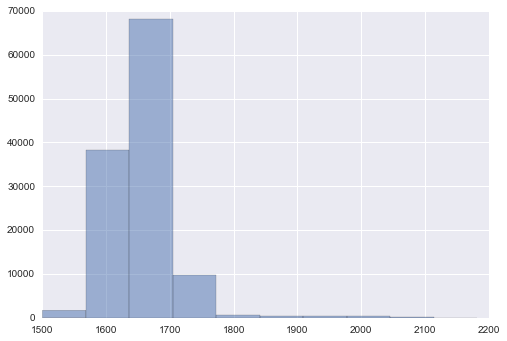

In [98]:
plt.hist(profiles[:,0][np.where(profiles[:,0]>1500)], alpha=0.5);
#plt.hist(profiles[:,2][np.where(profiles[:,0]>1500)], alpha=0.5)
#plt.hist(profiles[:,4][np.where(profiles[:,0]>1500)], alpha=0.5)

In [80]:
profiles_viz=np.copy(profiles)
profiles_viz[vizmask]=0

In [85]:
darkness=0.6
figsize_left = (10,9)
figsize_right = (10,7.3)
figsize_dorsal = (10,10)
darkness=0.6

In [ ]:
sns.set_context(None)
cropped_img = []
vmin=1500
vmax=1800
data = profiles_viz[:,0]
cmap=cmocean.cm.tempo_r
sns.set_style('white')
for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_left,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(180, 0), (180, 180)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:],  cmap=cmap, 
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_right,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

for (elev, azim) in [(270, 90)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_dorsal,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))


for (elev, azim) in [(270, 90)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], cmap=cmap,
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_dorsal,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))
#(occ, 200, 90)

for (elev, azim) in [(190, 90)]:
    plot=plot_surf_stat_map(lv, lf, stat_map=data[:lv.shape[0]], cmap=cmap,
                            bg_map=lh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_left,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))


for (elev, azim) in [(190, 85)]:
    plot=plot_surf_stat_map(rv, rf, stat_map=data[lv.shape[0]:], cmap=cmap,
                            bg_map=rh_sulc, bg_on_stat=True,darkness=darkness, 
                            elev=elev,azim=azim, figsize=figsize_right,threshold=1200, 
                            symmetric_cbar=False, vmin=vmin, vmax=vmax)
    cropped_img.append(crop_img(plot))

In [ ]:
fig=brain_fig(cropped_img[0:4])
#fig.savefig(pic_folder+'myelin_lateral_medial.png')

fig=dorsal_fig(cropped_img[4:6])
#fig.savefig(pic_folder+'myelin_dorsal.png')

fig=brain_fig(cropped_img[6:8])
#fig.savefig(pic_folder+'myelin_occ.png')

sns.set_style('whitegrid')
sns.set_context('notebook', font_scale=4)
cmap = cmocean.cm.tempo_r
norm = mpl.colors.Normalize(vmin=1700, vmax=2300)

fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_axes([0.05, 0.05, 0.05, 0.9])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='vertical', ticks=[1700, 1900, 2100, 2300])
#fig.savefig(pic_folder+'myelin_cbar.svg')
fig = plt.figure(figsize=(6.5, 4))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
mpl.colorbar.ColorbarBase(ax1, cmap=cmap,norm=norm,orientation='horizontal', ticks=[1700, 1900, 2100, 2300])
#fig.savefig(pic_folder+'myelin_cbar_horizontal.svg')
sns.set()